In [37]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dot, Reshape
from keras.layers import Input, LSTM, GRU, Bidirectional, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score

from keras.optimizers import Adam, SGD
import keras.backend as K

In [2]:
def get_toxic_data(file_name):
    train = pd.read_csv(file_name)
    sentences = train["comment_text"].fillna("DUMMY_VALUE").values
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    targets = train[labels].values
    return sentences, labels, targets

In [3]:
toxic_train_file_path = 'data/train.csv'
toxic_test_file_path = 'data/test.csv'

In [5]:
sentences, labels, targets = get_toxic_data(toxic_train_file_path)

In [6]:
max_vocab_size = 20000

In [8]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# IMPORTANT
#  1. the index starts from 1 instead of 0
#  2. the word index dictionary does not honor the number of words constraint
word2index = tokenizer.word_index

In [9]:
print(len(word2index))

210337


In [10]:
def get_word2vec(file_name):
    word2vec = {}
    with open(file_name, 'r') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vec = np.array(values[1:], dtype=np.float32)
            word2vec[word] = vec
    return word2vec

In [11]:
word2vec_file_path = 'data/glove.6B.50d.txt'

In [12]:
word2vec = get_word2vec(word2vec_file_path)

In [13]:
max_squence_length = 100

In [14]:
data = pad_sequences(sequences, maxlen=max_squence_length)
print(data.shape)

(159571, 100)


In [16]:
embedding_dim = 50
num_vocab = min(max_vocab_size + 1, len(word2index) + 1)

embedding_matrix = np.zeros((num_vocab, embedding_dim))
for word, index in word2index.items():
    if index <= max_vocab_size:
        vec = word2vec.get(word)
        if vec is not None:
            embedding_matrix[index] = vec

In [17]:
print(embedding_matrix.shape)

(20001, 50)


In [18]:
type(data)
train_data = data[:140000]
test_data = data[140000:]
train_targets = targets[:140000]
test_targets = targets[140000:]
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(140000, 100)
(19571, 100)
(140000, 6)
(19571, 6)


In [19]:
embedding = Embedding(
            embedding_matrix.shape[0],
            embedding_matrix.shape[1],
            weights = [embedding_matrix],
            input_length=max_squence_length,
            trainable=True,    
            name='encoder_embed')


In [20]:
latent_dim = 192

In [24]:
encoder_input_placeholder = Input(shape=(max_squence_length,), name = 'encoder_inputs')
encoder_input_x = embedding(encoder_input_placeholder)

encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, dropout=0.5), name='encoder_bidirectional_lstm')

encoder_lstm_outputs = encoder_lstm(encoder_input_x)

In [25]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [41]:
x = Dense(10, activation='tanh', name='attn_weights_dense_1')(encoder_lstm_outputs)
alphas = Dense(1, activation=softmax_over_time, name='attn_weights_dense_2')(x)
encoding = Dot(axes=1,name='attn_dot_layer')([alphas, encoder_lstm_outputs])

output = Dense(len(labels), activation='sigmoid')(encoding)

output = Reshape((len(labels),))(output)

model = Model(encoder_input_placeholder, output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 50)      1000050     encoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_bidirectional_lstm (Bid (None, 100, 384)     373248      embedding_1[1][0]                
__________________________________________________________________________________________________
attn_weights_dense_1 (Dense)    (None, 100, 10)      3850        encoder_bidirectional_lstm[0][0] 
__________________________________________________________________________________________________
attn_weigh

In [42]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [43]:
validation_split = 0.2
batch_size = 512
epochs = 10

r = model.fit(train_data, train_targets, batch_size=batch_size, epochs = epochs, validation_split=validation_split)

Train on 112000 samples, validate on 28000 samples
Epoch 1/10
112000/112000 [==============================] - 1457s 13ms/step - loss: 0.0911 - acc: 0.9703 - val_loss: 0.0642 - val_acc: 0.9798
Epoch 2/10
112000/112000 [==============================] - 1310s 12ms/step - loss: 0.0536 - acc: 0.9809 - val_loss: 0.0496 - val_acc: 0.9818
Epoch 3/10
112000/112000 [==============================] - 1520s 14ms/step - loss: 0.0467 - acc: 0.9826 - val_loss: 0.0501 - val_acc: 0.9819
Epoch 4/10
112000/112000 [==============================] - 1218s 11ms/step - loss: 0.0429 - acc: 0.9836 - val_loss: 0.0489 - val_acc: 0.9824
Epoch 5/10
112000/112000 [==============================] - 1235s 11ms/step - loss: 0.0407 - acc: 0.9842 - val_loss: 0.0488 - val_acc: 0.9826
Epoch 6/10
112000/112000 [==============================] - 1200s 11ms/step - loss: 0.0375 - acc: 0.9853 - val_loss: 0.0499 - val_acc: 0.9819
Epoch 7/10
112000/112000 [==============================] - 1358s 12ms/step - loss: 0.0355 - acc:

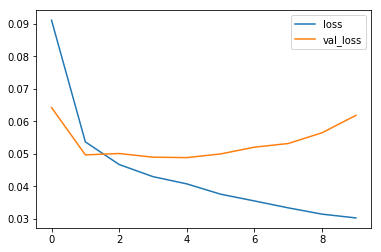

In [44]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

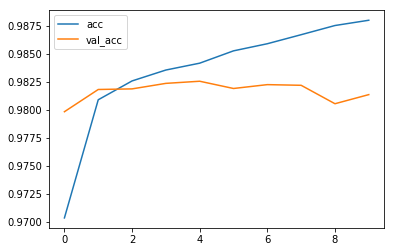

In [45]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [46]:
p = model.predict(test_data)

In [47]:
aucs = []
for j in range(6):
    auc = roc_auc_score(test_targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

0.9738869956394209
